# Examples <br>



Before starting, remember to activate the environment:  <br>
**source env/bin/activate**





In [1]:
from intrinsic_dimension import intrinsic_dimension, section_id, secondary_structure_id
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib as mpl
import seaborn as sns
import logging
from moleculekit.molecule import Molecule

To provide examples of ID applications, we used trajectories of fast folding proteins generated by D. E. Shaw group ([DOI:10.1126/science.1208351](https://pubmed.ncbi.nlm.nih.gov/22034434/)). 

In particular, we used chicken villin headpiece (PDB: 2F4K), a 35 residue long protein with two point mutations, K65(NLE) and K70(NLE), to increase the folding speed up to 5 times in respect to wild-type.  

We used protein structure and trajectory data of DESRES-Trajectory_2F4K-0-protein. 
We sampled the originally simulated trajectory in 6 shorter sub-trajectories of 2000 frames each, representing either the folded state of the protein (1, 3, 5) or the unfolded one (0, 2, 4).
| Original Trajectory    | New Trajectory | Frames    | State |
|------------------------|----------------|-----------|-------|
|2F4K-0-protein-000.dcd  |2F4K_0.xtc      |[0:2000]   | Unfolded |
|2F4K-0-protein-001.dcd  |2F4K_1.xtc      |[0:2000]   | Folded   |
|2F4K-0-protein-001.dcd  |2F4K_2.xtc      |[5000:7000]| Unfolded |
|2F4K-0-protein-004.dcd  |2F4K_3.xtc      |[8000:]    | Folded |
|2F4K-0-protein-005.dcd  |2F4K_4.xtc      |[1700:3700]| Unfolded |
|2F4K-0-protein-005.dcd  |2F4K_5.xtc      |[5000:7000]| Folded |



In [2]:
topology='examples/villin/2F4K.pdb'
trajectory='examples/villin/2F4K'
protein = 'villin'

projection_method = 'Dihedrals'  # or 'Distances'
projection_kwargs = {'skip': 3}

data = []
states = [0,1,2,3,4,5] 


for state in states:
    mean_all, mean_last, local_id = intrinsic_dimension(topology=topology, trajectory=trajectory+f'_{state}.xtc', projection_method=projection_method, projection_kwargs = projection_kwargs,id_method='local', verbose=False)
	
    data.append({'trajectory': state,
	  'mean_all': mean_all,
	  'mean_last': mean_last,
      'local_id': local_id,
      })
data = pd.DataFrame(data)
data['folded'] = data['trajectory'] % 2 != 0

In [3]:
#build personalised cmap
colors = mpl.colors.ListedColormap(
    name="discrete-monochromatic-blue",
    colors=["#CEFF29", "#5c8dff","#ACE000", "#004dff", "#6d8f00", "#0037b8"])

By computing ID as ``local`` it is possible to see how this value evolves along the trajectory, we called it **Instantaneous ID**.

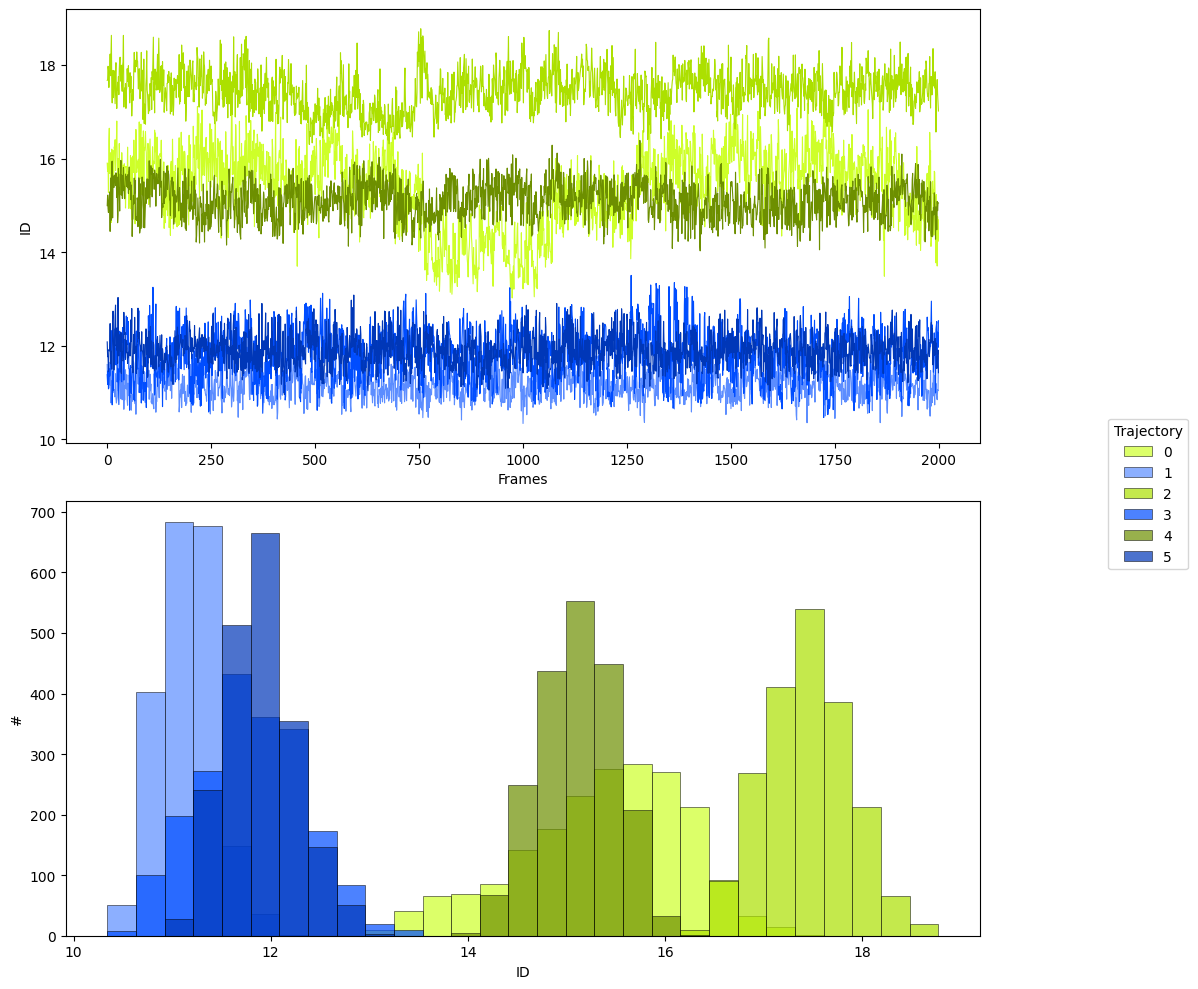

In [12]:
fig, ax = plt.subplots(figsize=(10, 10), nrows=2)
 
#instantaneous id
for i, s in enumerate(data['trajectory']):
    local_id = data.loc[i, 'local_id']
    frames = np.arange(len(local_id))
    ax[0].plot(frames, local_id, color=colors.colors[i], linewidth=0.8)

ax[0].set_xlabel("Frames")
ax[0].set_ylabel("ID")
      

#####################
#id frequency
all_values = np.concatenate(data['local_id'].values)  # concatenate all local_id arrays
bins = np.linspace(all_values.min(), all_values.max(), 30)

for i, state in enumerate(data['trajectory']):
    local_id = data.loc[i, 'local_id']
    ax[1].hist(local_id, bins=bins, alpha=0.7, label=f"{state}", color=colors.colors[i], edgecolor='black', linewidth=0.5)

ax[1].set_xlabel("ID")
ax[1].set_ylabel("#")
#ax[1].set_title("Frequency")

fig.legend(bbox_to_anchor=(1.20, 0.5), loc="center right", title='Trajectory')
plt.tight_layout()
plt.savefig('../bin/villin_instantaneous_ID_distance.png', dpi=300)
plt.show()


The trajectories are clearly split in two ID groups, so we can divide the trajectories in "folded" and "unfolded" by setting a threshold at ID<13, this shows the capability of ID to identify the two distinct states. 

This can be done both with ``local`` (including standard deviations) ID and the mean of the ``global`` ID along the trajectory.



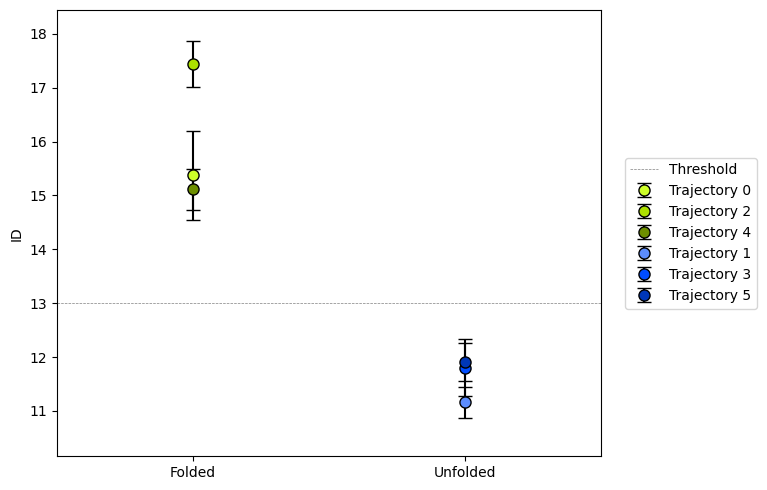

In [13]:
data['folded'] = data['mean_all'] < 13  # threshold based on instantaneous ID distributions

plt.figure(figsize=(8, 5))
group_labels = {True: "Folded", False: "Unfolded"}

for i, (key, group) in enumerate(data.groupby('folded')):
    x_base = i  # 0 for folded, 1 for unfolded
    for _, row in group.iterrows():
        x = x_base
        y = row['mean_all']
        std_val = np.std(row['local_id'])
        color_idx = states.index(row['trajectory'])  # use 'trajectory' column
        plt.errorbar(x, y, yerr=std_val,color=colors.colors[color_idx],fmt='o',markeredgecolor='black',ecolor='black',capsize=5,markersize=8,label=f"Trajectory {row['trajectory']}")

plt.xticks([0, 1], ['Folded', 'Unfolded'])
plt.xlim(-0.5, 1.5)
plt.hlines(y=13, xmin=-0.5, xmax=1.5, linestyles="--", colors="gray", linewidth=0.5, label="Threshold")
plt.ylabel("ID")
plt.ylim(data['mean_all'].min() - 1, data['mean_all'].max() + 1)
plt.legend(bbox_to_anchor=(1.30, 0.5), loc="center right")
plt.tight_layout()
plt.savefig('../bin/villin_average_ID_dihedral.png')
plt.show()


Similarly, with <span class="mark"><code>section_id</code></span>, it is possible to visualise, for each window, the value of ID along the trajectory (both as ``global`` ID and ``local``).

In this case it is intresting to notice how some of the windows show a clearer separation between folded and unfolded trajectories than others, for example window 42-56 compared to window 51-56.

In [20]:
states = [0, 1, 2, 3, 4, 5]
all_results = []
for s in states: 
    results = section_id(topology='examples/villin/2F4K.pdb', trajectory=f'examples/villin/2F4K_{s}.xtc', window_size = 15, stride = 3, projection_method='Dihedrals', id_method='local', verbose=False)
    results["trajectory"] = s  
    all_results.append(results)
results = pd.concat(all_results, ignore_index=True)
results['folded'] = results['trajectory'] % 2 != 0
results['window'] = results["start"].astype(str) + "-" + results["end"].astype(str)

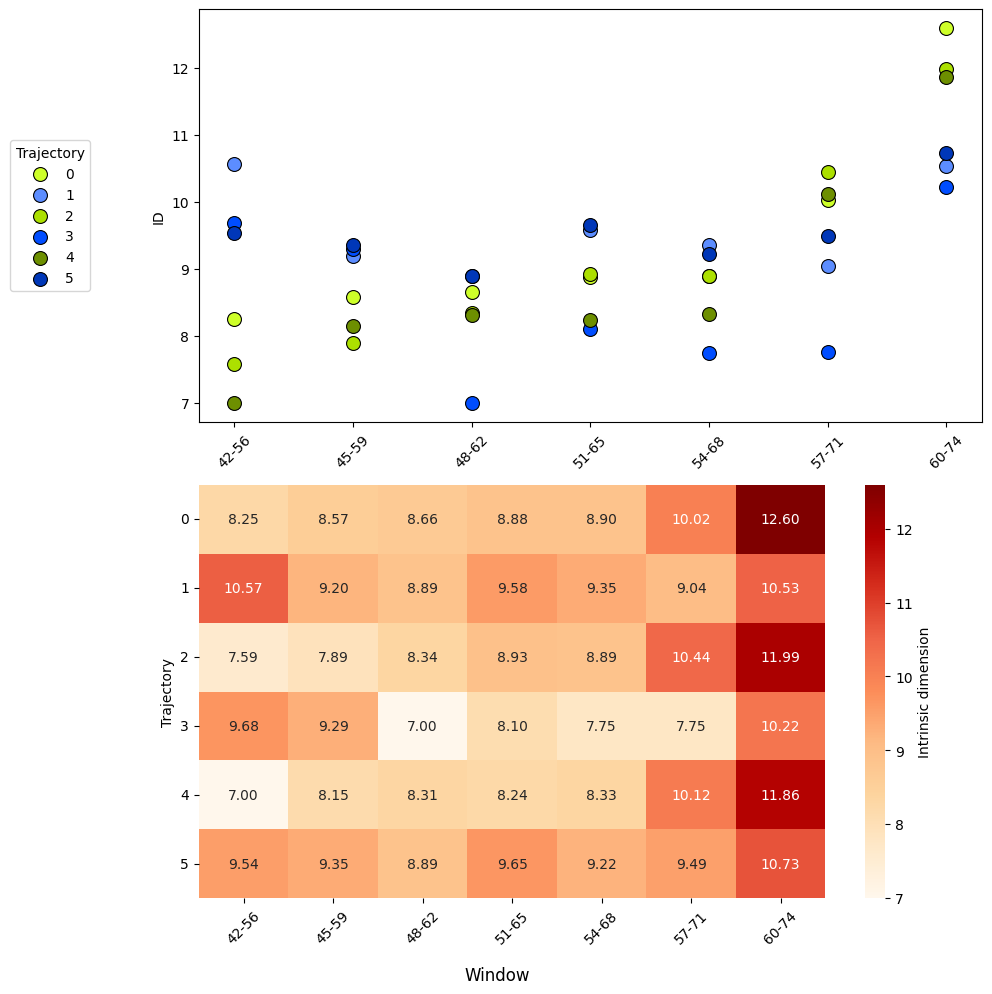

In [23]:
grouped_data = results.groupby(['trajectory', 'window'], as_index=False)['entire simulation'].mean()
pivot_data = grouped_data.pivot(index='trajectory', columns='window', values='entire simulation')
ordered_cols = sorted(pivot_data.columns, key=lambda w: int(w.split("-")[0]))
pivot_data = pivot_data[ordered_cols]

fig, axes = plt.subplots(figsize=(10, 10), nrows = 2)

#ID by segment
for i, (state, color) in enumerate(zip(states, colors.colors)):
    subset = results[results['trajectory'] == state]
    x = subset['window']
    y = subset['entire simulation']
    axes[0].scatter(x, y, color=colors.colors[i], edgecolor='black', linewidth=0.8, s=100, label=f"{state}")

axes[0].set_xticks(sorted(results['window'].unique(), key=lambda w: int(w.split("-")[0])))
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_ylabel("ID")
axes[0].legend(title="Trajectory", bbox_to_anchor=(-0.25, 0.5), loc='center left')

#ID value
pivot_data.columns.name = None
sns.heatmap(pivot_data, cmap="OrRd", annot=True, fmt=".2f", ax=axes[1], cbar_kws={'label': 'Intrinsic dimension'})
axes[1].set_ylabel("Trajectory")
axes[1].tick_params(axis='x', rotation=45, labelrotation=45)
axes[1].tick_params(axis='y', rotation=0)

fig.supxlabel("Window")
plt.tight_layout()
plt.savefig('../bin/villin_global_ID_sections.png')
plt.show()


<span class="mark"><code>secondary_structure_id</code></span>, divides the protein by secondary structure elements instead of same-length windows, estimating ID along the trajectory on each element individually (both as ``global`` ID and ``local``). 

Computing ID separately for each secondary structure element provides more detailed insights into the protein’s flexibility, as different types of secondary structures comprise distinct levels of flexibility in specific regions.

In [2]:
states = [0, 1, 2, 3, 4, 5]
all_results = []
ss_assignments = []
residue_numbers = None
mol_ref = Molecule('examples/villin/2F4K.pdb', validateElements = False)

for s in states:
    results, ss_table = secondary_structure_id(topology='examples/villin/2F4K.pdb', trajectory=f'examples/villin/2F4K_{s}.xtc', simplified=False, projection_method='Dihedrals', id_method='local' , verbose=False)
    results['trajectory'] = s  
    if residue_numbers is None:
        residue_numbers = ss_table['resid index'].values
    ss_assignments.append(ss_table['sec str type'].values)
    results['trajectory'] = s   
    all_results.append(results)

results = pd.concat(all_results, ignore_index=True)
results['folded'] = results['trajectory'] % 2 != 0
results['window'] = results["start"].astype(str) + "-" + results["end"].astype(str)

TypeError: '>' not supported between instances of 'property' and 'int'

In [24]:

ss_types = ['H', 'B', 'C', 'E', 'G', 'T', 'S', ' ']
ss_colors = {"H": "crimson","B": "darkorange", 'C': 'steelblue', "E": "gold", "G": "mediumvioletred","T": "deepskyblue","S": "mediumseagreen", " ": "dimgray"}

grouped_data = results.groupby(['trajectory', 'window'], as_index=False)['entire simulation'].mean()
pivot_data = grouped_data.pivot(index='trajectory', columns='window', values='entire simulation')
ordered_cols = sorted(pivot_data.columns, key=lambda w: int(w.split("-")[0]))
pivot_data = pivot_data[ordered_cols]

fig, axes = plt.subplots(3, 1, figsize=(15, 15))

#ss of each residue
ss_to_num = {ss: i for i, ss in enumerate(ss_types)}
num_data = np.array([[ss_to_num[ss] for ss in row] for row in ss_assignments])
cmap = ListedColormap([ss_colors[ss] for ss in ss_types])
im = axes[0].imshow(num_data, aspect='auto', cmap=cmap, extent=[residue_numbers[0]-0.5, residue_numbers[-1]+0.5, len(states)-0.5, -0.5])
for x in np.arange(residue_numbers[0]-0.5, residue_numbers[-1]+1.5, 1):
    axes[0].axvline(x=x, color='white', linewidth=0.5, alpha=0.5)
for y in np.arange(-0.5, len(states)+0.5, 1):
    axes[0].axhline(y=y, color='white', linewidth=0.5, alpha=0.5)
axes[0].grid(False)
axes[0].set_xticks(residue_numbers)
axes[0].set_yticks(np.arange(len(states)))
axes[0].set_yticklabels([f"{t}" for t in states])
axes[0].set_xlabel('Residue Number')
axes[0].tick_params(axis='x', rotation=50)  

legend_elements = [plt.Rectangle((0,0), 1, 1, color=ss_colors[ss], label=ss) for ss in ss_types]
axes[0].legend(handles=legend_elements, bbox_to_anchor=(1.13, 0.5), loc='center right', title='Secondary Structure')

#ID distribution
for i, (state, color) in enumerate(zip(states, colors.colors)):
    subset = results[results['trajectory'] == state]
    x = subset['window']
    y = subset['entire simulation']
    axes[1].scatter(x, y, color=colors.colors[i], edgecolor='black', linewidth=0.8, s=100, label=f"{state}")

axes[1].set_xticks(sorted(results['window'].unique(), key=lambda w: int(w.split("-")[0])))
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_ylabel("ID")
axes[1].set_xlabel("Secondary Structure Element")
axes[1].legend(title="Trajectory", bbox_to_anchor=(1.10, 0.5), loc='center right')

#ID value
pivot_data.columns.name = None
sns.heatmap(pivot_data, cmap="OrRd", annot=True, fmt=".2f", ax=axes[2], cbar_kws={'label': 'Intrinsic dimension'})
axes[2].set_ylabel("Trajectory")
axes[2].set_xlabel("Secondary Structure Element")
axes[2].tick_params(axis='x', rotation=45, labelrotation=45)
axes[2].tick_params(axis='y', rotation=0)


plt.tight_layout()
plt.savefig('../bin/villin_global_ID_ss_dihedrals.png')
plt.show()


KeyError: 'state'